# ◆[Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic/data)
### 目的：タイタニック号の乗客のデータから、生存予測をする
- 目的変数をSurvivedとする二値分類問題を複数のアルゴリズムを掛け合わせたモデルを構築する
##### Create Date：2020/01/08　Author：M.Hasegawa

### ────────────────────────────────────────────────────────────────

#### 【手順】
0. [**Notebook内で利用する関数の定義**](#import_module)
1. [**データ読込**](#import_data)
2. [**特徴量の抽出**](#feature_extraction)
3. [**前処理**](#prepearing)・・・カテゴリ変換
4. [**モデル構築と評価**](#modeling)・・・学習曲線、重要な特徴量
5. [**テストデータ予測**](#submission)

#### ※データセット
- 「train.csv」（学習データ数：891行12列）
- 「test.csv」（テストデータ数：418行11列 ※Survived列がない）

| 列 | 項目 | 項目名 | 欠損有無 | 利用有無 |
| :--- | :--- | :--- | :---: | :---: |
|  1 | PassengerId |識別ID | - | - |
|  2 | Survived | 生存有無 | - | ○ |
|  3 | Pclass | チケットクラス | - | ○ |
|  4 | Name | 名前 | - | - |
|  5 | Sex | 性別 | - | ○ |
|  6 | Age | 年齢 | 欠損あり | ○ |
|  7 | SibSp | タイタニック号に乗る兄弟/配偶者の数 | - | ○ |
|  8 | Parch | タイタニック号に乗る親/子供の数 | - | ○ |
|  9 | Ticket | チケット | - | - |
| 10 | Fare | 旅客運賃 | 欠損あり | ○ |
| 11 | Cabin | 客室番号 | 欠損あり | - |
| 12 | Embarked| 乗船港 C =シェルブール、Q =クイーンズタウン、S =サザンプトン | 欠損あり | ○ |

## 0. Notebook内で利用する関数の定義<a id='import_module'></a>

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.metrics         import accuracy_score
from sklearn.metrics         import confusion_matrix
from sklearn.linear_model    import LogisticRegression
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.tree            import DecisionTreeClassifier
from sklearn.naive_bayes     import GaussianNB
from sklearn.svm             import SVC
from sklearn.ensemble        import RandomForestClassifier
from sklearn.ensemble        import ExtraTreesClassifier
from sklearn.ensemble        import AdaBoostClassifier
from sklearn.ensemble        import GradientBoostingClassifier
from sklearn.ensemble        import VotingClassifier

sns.set_style('whitegrid')
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# 再現性の為の固定値
seed      = 42 #42
num_folds = 10 #10

#random seeds
np.random.seed(seed)

In [2]:
# ============================================================================
# 関数：アルゴリズム交差検証
# 引数：モデル群、学習データX、学習データy
# ============================================================================
def algo_cross_validation(models, X_train, y_train, seed):
    results = []
    names   = []
    for name, model in models:
        kfold = KFold(n_splits=num_folds, random_state=seed)
        # k分割交差検証法の結果（cv=交差検証回数、scoring=評価指標）
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
        results.append(cv_results) # 分割数分のスコア
        names.append(name)
        # スコア平均と標準偏差
        msg = "%s スコア平均：%f (標準偏差：%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    return names, results

# ============================================================================
# 関数：モデルの箱ひげ図を生成
# 引数：モデル名、交差検証結果
# ============================================================================
def show_boxplot_compare_algo(names, results):
    fig = plt.figure(figsize=(6, 4)) 
    ax = fig.add_subplot(111)
    sns.boxplot(data=results)
    ax.set_xticklabels(names) 
    plt.title('Comparison between Algorithms', size = 12, color='k')
    plt.xlabel('Percentage',size = 12,color="k")
    plt.ylabel('Algorithm',size = 12,color="k")
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.show()

# ============================================================================
# 関数：ハイパーパラメータチューニング
# 引数：モデル、パラメータ、学習データX、学習データy
# ============================================================================
def algo_grid_search(model, param_grid, X_train, y_train, seed):
    kfold = KFold(n_splits=num_folds, random_state=seed)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=kfold, n_jobs=-1)
    grid_result = grid.fit(X_train, y_train)
    best_estimator = grid_result.best_estimator_
    print("BestScore: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    print("-"*60)
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    #for mean, stdev, param in zip(means, stds, params):
        #print("Score: %f (%f) with: %r" % (mean, stdev, param))
        #print("-"*60)
    return best_estimator

# ============================================================================
# テストおよびトレーニング学習曲線の簡単なプロットを生成
# モデル、タイトル、X,y
# ============================================================================
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(6,4))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim) # Y軸の範囲
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy Score")
    
    # 学習曲線
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1) # 分割数分のスコアの平均
    train_scores_std  = np.std(train_scores, axis=1) # 分割数分のスコアの標準偏差
    test_scores_mean  = np.mean(test_scores, axis=1) # 分割数分のスコアの平均
    test_scores_std   = np.std(test_scores, axis=1) # 分割数分のスコアの標準偏差
    
    plt.grid()
    # 標準偏差の範囲を色付け（学習データ）
    plt.fill_between(train_sizes, 
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, 
                     alpha=0.1,
                     color="r")
    # 標準偏差の範囲を色付け（交差検証法）
    plt.fill_between(train_sizes, 
                     test_scores_mean - test_scores_std, 
                     test_scores_mean + test_scores_std, 
                     alpha=0.1, color="g")
    # 学習データのスコアをプロット
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    # 交差検証法スコアをプロット
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

# ============================================================================
# 重みを横棒グラフで表示
# ============================================================================
def show_plot_feature(best_model, datacols, title):
    plt.figure(figsize=(10,4))
    pd.Series(best_model.feature_importances_,datacols).sort_values(ascending=True).plot.barh(width=0.8)
    plt.title(title)
    plt.show()

# 1. データ読込<a id='import_data'><a>

In [3]:
df_train = pd.read_csv('./train.csv')
df_test  = pd.read_csv('./test.csv')

print('\n▼ Datasets shapes: ')
print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)

# 欠損データチェック
display(pd.DataFrame(df_train.isnull().sum()[df_train.isnull().sum()>0],columns=['Train Missing num']))
display(pd.DataFrame(df_test.isnull().sum()[df_test.isnull().sum()>0],columns=['Test Missing num']))

df_train.drop("Cabin", axis=1, inplace = True)
df_test.drop("Cabin", axis=1, inplace = True)

# 欠損データ補完
df_train["Age"].fillna(df_train["Age"].median(), inplace = True)
df_test["Age"].fillna(df_test["Age"].median(),  inplace = True)
df_test["Fare"].fillna(df_test['Fare'].median(), inplace = True)
df_train['Embarked'] = df_train['Embarked'].fillna(df_train['Embarked'].mode()[0])

# 欠損データチェック
#display(pd.DataFrame(df_train.isnull().sum()[df_train.isnull().sum()>0],columns=['Train Missing num']))
#display(pd.DataFrame(df_test.isnull().sum()[df_test.isnull().sum()>0],columns=['Test Missing num']))


▼ Datasets shapes: 
Train shape: (891, 12)
Test shape: (418, 11)


,Train Missing num
Age,177
Cabin,687
Embarked,2


,Test Missing num
Age,86
Fare,1
Cabin,327


# 2. 特徴量の抽出<a id='feature_extraction'></a>

In [4]:
# 説明変数の前処理
all_data = [df_train, df_test]
def featureExtraction(all_data):
    
    # SibSpとParchの組み合わせとしてFamilySizeを作成
    for dataset in all_data:
        dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
        
    # 年齢の階級を作成
    for dataset in all_data:
        dataset['Age_bin'] = pd.cut(dataset['Age'], bins=[0,18,60,120], labels=['Children','Adult','Elder'])
    
    # 名前の特徴からタイトルを作成
    for dataset in all_data:
        dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    
    # タイトルを置換
    for dataset in all_data:
        dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',
                                                 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
        dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
        dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
        dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

featureExtraction(all_data)

# 3. 前処理<a id='prepearing'></a>

In [5]:
# ダミー変換
dfTrain = df_train.copy()
dfTest  = df_test.copy()

traindf = pd.get_dummies(dfTrain, columns = ["Pclass","Title",'FamilySize',"Sex","Age_bin","Embarked"],
                             prefix=["Pclass","Title",'FamilySize',"Sex","Age_type","Em_type"])

testdf = pd.get_dummies(dfTest, columns = ["Pclass","Title",'FamilySize',"Sex","Age_bin","Embarked"],
                             prefix=["Pclass","Title",'FamilySize',"Sex","Age_type","Em_type"])

allData = [traindf, testdf]

# ダミー変数にしたものは除外
for dataset in allData:
    drop_column = ["Age","Fare","Name","Ticket","SibSp","Parch"]
    dataset.drop(drop_column, axis=1, inplace = True)

traindf.drop(["PassengerId"], axis=1, inplace = True)

In [6]:
# 行番号をシャッフル
df_data_shuffled = traindf.iloc[np.random.permutation(len(traindf))]
array = df_data_shuffled.values
features = array[:,1:].astype(float) # X：説明変数 1列目以降すべて
targeted = array[:,0].astype(float)  # y：目的変須 0列目

X_train,X_test,y_train,y_test = train_test_split(features,targeted,test_size=0.33,random_state=seed)

print('Data shapes: ')
print("X_train shape: ", X_train.shape)
print("X_test shape : ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape : ", y_test.shape)

Data shapes: 
X_train shape:  (596, 25)
X_test shape :  (295, 25)
y_train shape:  (596,)
y_test shape :  (295,)


# 4. モデル構築<a id='modeling'></a>

## 4-1. 標準アルゴリズム検証

LR スコア平均：0.830480 (標準偏差：0.047499)
KNN スコア平均：0.798785 (標準偏差：0.050362)
CART スコア平均：0.795141 (標準偏差：0.050853)
NB スコア平均：0.446328 (標準偏差：0.029200)
SVM スコア平均：0.808729 (標準偏差：0.055310)


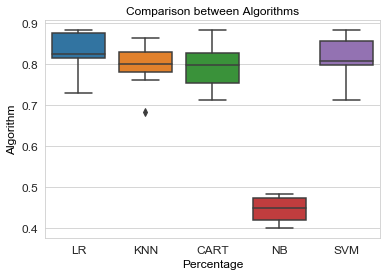

In [7]:
# 各アルゴリズムを交差検証法で評価
models = [('LR', LogisticRegression(solver='liblinear')), # ロジスティック回帰
          ('KNN', KNeighborsClassifier()), # K-近傍法
          ('CART', DecisionTreeClassifier()), # 決定木
          ('NB', GaussianNB()), # ガウシアン型ナイーブベイズ
          ('SVM', SVC(gamma='auto')) # サポートベクターマシン
         ]
names,results = algo_cross_validation(models,X_train,y_train,seed)
show_boxplot_compare_algo(names, results)

### 4-1-1. ロジスティック回帰

In [8]:
lr_clf = LogisticRegression()
#lr_param_grid = {'solver' : ['liblinear', 'lbfgs'],'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
lr_param_grid = {'solver' : ['liblinear'],'C': [1] }
best_lr = algo_grid_search(lr_clf, lr_param_grid, X_train, y_train, seed)
print('BestModel:',best_lr)

BestScore: 0.830537 using {'C': 1, 'solver': 'liblinear'}
------------------------------------------------------------
BestModel: LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)


### 4-1-2.K-近傍法

In [9]:
knn_clf = KNeighborsClassifier()
#knn_param_grid = {'n_neighbors':[3,5,7,9,11],'leaf_size':[1,2,3,5],'weights':['uniform', 'distance'],
#              'algorithm':['auto', 'ball_tree','kd_tree','brute']}
knn_param_grid = {'n_neighbors':[7],'leaf_size':[2],'weights':['uniform'],
              'algorithm':['ball_tree']}
best_knn = algo_grid_search(knn_clf, knn_param_grid, X_train, y_train, seed)
print('BestModel:',best_knn)

BestScore: 0.823826 using {'algorithm': 'ball_tree', 'leaf_size': 2, 'n_neighbors': 7, 'weights': 'uniform'}
------------------------------------------------------------
BestModel: KNeighborsClassifier(algorithm='ball_tree', leaf_size=2, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=7, p=2,
           weights='uniform')


### 4-1-3. 決定木

In [10]:
dt_clf = DecisionTreeClassifier()
#dt_param_grid = {'max_depth' : [3,4,5,6,7,8,9,10],'max_features': ['sqrt', 'log2'],
#              'min_samples_split': [3,5,7,9,11], 'min_samples_leaf':[1,3,5,7,9,11]}
dt_param_grid = {'max_depth' : [7],'max_features': ['sqrt'],
              'min_samples_split': [5], 'min_samples_leaf':[5]}
best_dt = algo_grid_search(dt_clf, dt_param_grid, X_train, y_train, seed)
print('BestModel:',best_dt)

BestScore: 0.798658 using {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5}
------------------------------------------------------------
BestModel: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


### 4-1-4. サポートベクターマシン

In [11]:
svc_clf = SVC()
#svc_param_grid = [{"kernel": ["rbf"], "gamma": [10 ,1, 0.1, 1e-2, 1e-3],"C": [0.1,1,10],"random_state" : [seed]},
#                  {"kernel": ["linear"], "C": [0.1,1,10,100]}]
svc_param_grid = [{"kernel": ["linear"], "C": [100]}]
best_SVC = algo_grid_search(svc_clf, svc_param_grid, X_train, y_train, seed)
print('BestModel:',best_SVC)

BestScore: 0.832215 using {'C': 100, 'kernel': 'linear'}
------------------------------------------------------------
BestModel: SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


## 4-2.アンサンブル法の検証

RFC スコア平均：0.808616 (標準偏差：0.054033)
ETC スコア平均：0.801893 (標準偏差：0.051767)
ABC スコア平均：0.802090 (標準偏差：0.043943)
GBC スコア平均：0.815424 (標準偏差：0.042594)


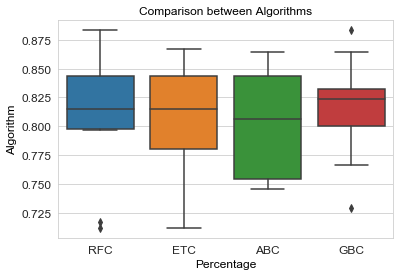

In [12]:
# 各アルゴリズムを交差検証法で評価
models = [('RFC', RandomForestClassifier(n_estimators=100)), # ランダムフォレスト
          ('ETC', ExtraTreesClassifier(n_estimators=100)), # ExtraTreesClassifier
          ('ABC', AdaBoostClassifier(n_estimators=100)), # アダブースト
          ('GBC', GradientBoostingClassifier(n_estimators=100)) # 勾配ブースティング
           ]
names,results = algo_cross_validation(models,X_train,y_train,seed)
show_boxplot_compare_algo(names, results)

### 4-2-1. AdaBoost

In [13]:
DTC = DecisionTreeClassifier()
ABC_clf = AdaBoostClassifier(DTC, random_state=seed)
#ABC_param_grid = {"base_estimator__criterion" : ["gini"], "base_estimator__splitter" :["best"],"algorithm" : ["SAMME"],
#                  "n_estimators" :[30, 100],"learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}
ABC_param_grid = {"base_estimator__criterion" : ["gini"], "base_estimator__splitter" :["best"],"algorithm" : ["SAMME"],
                  "n_estimators" :[30],"learning_rate":  [0.0001]}
best_ABC = algo_grid_search(ABC_clf, ABC_param_grid, X_train, y_train, seed)
print('BestModel:',best_ABC)

BestScore: 0.815436 using {'algorithm': 'SAMME', 'base_estimator__criterion': 'gini', 'base_estimator__splitter': 'best', 'learning_rate': 0.0001, 'n_estimators': 30}
------------------------------------------------------------
BestModel: AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.0001, n_estimators=30, random_state=42)


### 4-2-2. AdaBoost ExtraTrees

In [14]:
ETC_clf = ExtraTreesClassifier()
#ETC_param_grid = {"max_depth": [30],"max_features": ['sqrt'], "min_samples_split": [2, 3, 5],"min_samples_leaf": [1, 3, 5],
#                  "bootstrap": [True],"n_estimators" :[300],"criterion": ["gini"]}
ETC_param_grid = {"max_depth": [30],"max_features": ['sqrt'], "min_samples_split": [2],"min_samples_leaf": [5],
                  "bootstrap": [True],"n_estimators" :[300],"criterion": ["gini"]}
best_ETC = algo_grid_search(ETC_clf, ETC_param_grid, X_train, y_train, seed)
print('BestModel:',best_ETC)

BestScore: 0.825503 using {'bootstrap': True, 'criterion': 'gini', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 300}
------------------------------------------------------------
BestModel: ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='gini',
           max_depth=30, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


### 4-2-3. GradientBoosting

In [15]:
GBC_clf = GradientBoostingClassifier()
#GBC_param_grid = {'loss' : ["deviance"],'n_estimators' : [100, 200, 300],'learning_rate': [0.1, 0.05, 0.01],
#                  'max_depth': [3, 5, 7],'min_samples_leaf': [1, 5, 9],'min_samples_split': [2, 6, 10],
#                  'max_features': ['sqrt', 'log2']}
GBC_param_grid = {'loss' : ["deviance"],'n_estimators' : [100],'learning_rate': [0.01],
                  'max_depth': [5],'min_samples_leaf': [5],'min_samples_split': [6],'max_features': ['log2']}
best_GBC = algo_grid_search(GBC_clf, GBC_param_grid, X_train, y_train, seed)
print('BestModel:',best_GBC)

BestScore: 0.832215 using {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 6, 'n_estimators': 100}
------------------------------------------------------------
BestModel: GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=5,
              max_features='log2', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=5, min_samples_split=6,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)


### 4-2-4 RandomForest

In [16]:
RFC_clf = RandomForestClassifier()
#RFC_param_grid = {"max_depth": [None],"max_features": [1, 3, 10],"min_samples_split": [2, 3, 10],"min_samples_leaf": [1, 3, 10],
#                 "bootstrap": [True, False],"n_estimators" :[100,300],"criterion": ["gini"]}
RFC_param_grid = {"max_depth": [None],"max_features": [1],"min_samples_split": [2],"min_samples_leaf": [3],
                 "bootstrap": [True, False],"n_estimators" :[300],"criterion": ["gini"]}
best_RFC = algo_grid_search(RFC_clf, RFC_param_grid, X_train, y_train, seed)
print('BestModel:',best_RFC)

BestScore: 0.828859 using {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 1, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 300}
------------------------------------------------------------
BestModel: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=1, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


## 4-3. 学習曲線

KFold(n_splits=10, random_state=42, shuffle=False)


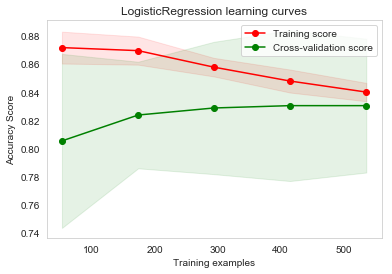

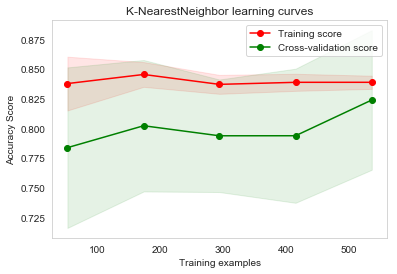

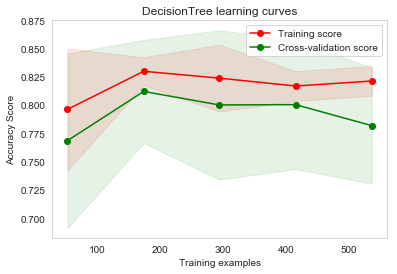

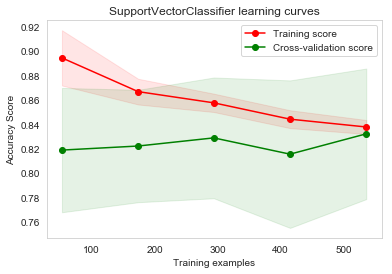

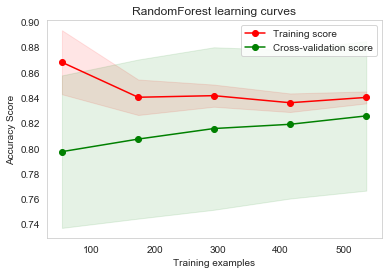

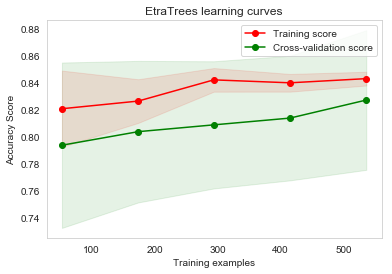

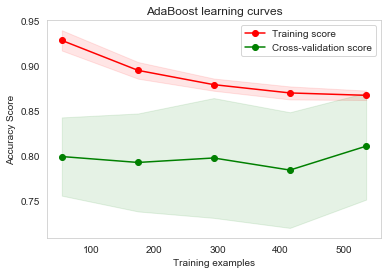

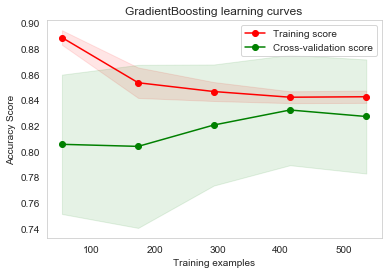

In [17]:
kfold = KFold(n_splits=num_folds, random_state=seed)
print(kfold)
plot_learning_curve(best_lr,"LogisticRegression learning curves",X_train,y_train,cv=kfold)
plot_learning_curve(best_knn,"K-NearestNeighbor learning curves",X_train,y_train,cv=kfold)
plot_learning_curve(best_dt,"DecisionTree learning curves",X_train,y_train,cv=kfold)
plot_learning_curve(best_SVC,"SupportVectorClassifier learning curves",X_train,y_train,cv=kfold)
plot_learning_curve(best_RFC,"RandomForest learning curves",X_train,y_train,cv=kfold)
plot_learning_curve(best_ETC,"EtraTrees learning curves",X_train,y_train,cv=kfold)
plot_learning_curve(best_ABC,"AdaBoost learning curves",X_train,y_train,cv=kfold)
plot_learning_curve(best_GBC,"GradientBoosting learning curves",X_train,y_train,cv=kfold)

## 4-4. アンサンブル法による特徴量の可視化

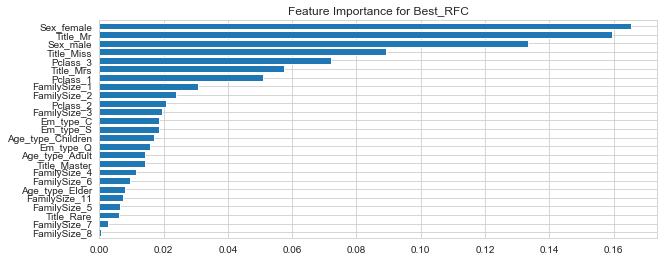

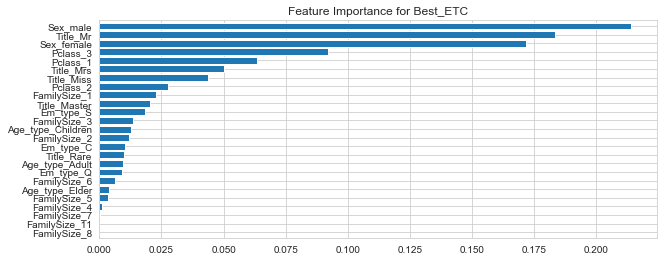

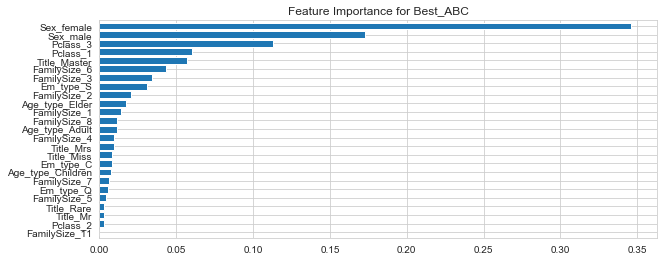

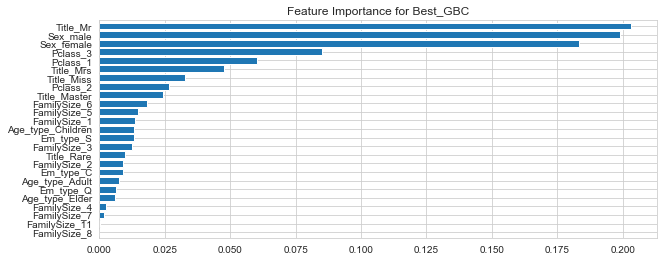

In [18]:
datacols = list(traindf.drop("Survived", axis=1))
show_plot_feature(best_RFC,datacols, 'Feature Importance for Best_RFC')
show_plot_feature(best_ETC,datacols, 'Feature Importance for Best_ETC')
show_plot_feature(best_ABC,datacols, 'Feature Importance for Best_ABC')
show_plot_feature(best_GBC,datacols, 'Feature Importance for Best_GBC')

## 4-4. アルゴリズムごとのヒートマップ表示 

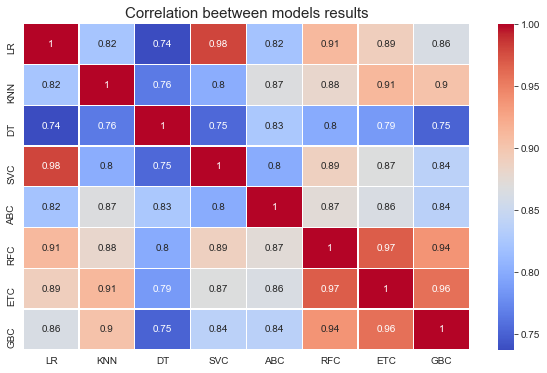

In [25]:
test = testdf.values
test_Survived_lr = pd.Series(best_lr.predict(test), name="LR")
test_Survived_knn = pd.Series(best_knn.predict(test), name="KNN")
test_Survived_dt = pd.Series(best_dt.predict(test), name="DT")
test_Survived_SVC = pd.Series(best_SVC.predict(test), name="SVC")
test_Survived_ABC = pd.Series(best_ABC.predict(test), name="ABC")
test_Survived_RFC = pd.Series(best_RFC.predict(test), name="RFC")
test_Survived_ETC = pd.Series(best_ETC.predict(test), name="ETC")
test_Survived_GBC = pd.Series(best_GBC.predict(test), name="GBC")

ensemble_results = pd.concat([test_Survived_lr, test_Survived_knn, 
                              test_Survived_dt, test_Survived_SVC,
                              test_Survived_ABC, test_Survived_RFC,
                              test_Survived_ETC, test_Survived_GBC],axis=1)


plt.figure(figsize =(10, 6))
sns.heatmap(ensemble_results.corr(),annot=True,cmap='coolwarm',linewidths=0.2)
plt.title('Correlation beetween models results', size=15)
plt.xticks(size=10)
plt.yticks(size=10)
plt.show()

## 4-5. アンサンブル学習

In [20]:
# sckit-learnのアンサンブル学習
passengerIds = testdf["PassengerId"].copy()
testdf.drop(["PassengerId"], axis=1, inplace = True)

# コンセプトの異なる機械学習分類器を組み合わせ、多数決や予測の平均(弱い投票)を使用し、クラスラベルを予測する
votingC = VotingClassifier(estimators=[('lr', best_lr),
                                       ('knn', best_knn),
                                       ('dt', best_dt),
                                       ('svc', best_SVC),
                                       ('abc', best_ABC),
                                       ('rfc', best_RFC),
                                       ('etc', best_ETC),
                                       ('gbc', best_GBC)], 
                           voting='hard', n_jobs=-1)
# 学習
votingC = votingC.fit(X_train, y_train)
#print(votingC)

# 5. テストデータ予測<a id='submission'></a>

In [21]:
predictions = votingC.predict(test)
test_Survived = pd.Series(votingC.predict(test), name="Survived")
test_Survived = test_Survived.apply(int)
results = pd.concat([passengerIds,test_Survived],axis=1)
results.to_csv('submission.csv', columns=['PassengerId', 'Survived'], index=False)